In [1]:
import numpy as np
from TDD2.TDD import Ini_TDD,Clear_TDD,set_index_order,get_tdd,Index,Slicing3,get_norm,cont
from TDD2.TDD_Q import cir_2_tn,get_real_qubit_num,add_trace_line,add_inputs,add_outputs
from TDD2.TDD_Q import reshape as reshape2
from TDD2.TN import Tensor,TensorNetwork
import time
from qiskit import QuantumCircuit
import pandas as pd
from func_timeout import func_set_timeout
import func_timeout

C:\ProgramData\Anaconda3\lib\site-packages\qiskit\__init__.py:64: RuntimeWarning: Could not import the Aer provider from the qiskit-aer package. Install qiskit-aer or check your installation.
  RuntimeWarning)


In [2]:
@func_set_timeout(3600)
def Equivalence_checking_of_DQC(cir1,cir2):

    tn1,indices=cir_2_tn(cir1)
    tn2,indices2=cir_2_tn(cir2)
    for k in indices2:
        if not k in indices:
            indices.append(k)

    Ini_TDD(indices)
    tdd1,max_node1=tn1.cont(optimizer='tree_decomposition')
    tdd2,max_node2=tn2.cont(optimizer='tree_decomposition')

    return tdd1,tdd2,max(max_node1,max_node2),tdd1==tdd2

In [3]:
def m_eq(tdd1,tdd2,index_set):
    if tdd1==tdd2:
        return True
    v1=tdd1.node.key
    v2=tdd2.node.key
    x=max(v1,v2)
    if v1>=v2:
        idx=tdd1.key_2_index[x]
    else:
        idx=tdd2.key_2_index[x]
        
    if idx in index_set:
        return m_eq(Slicing3(tdd1,x,0),Slicing3(tdd2,x,0),index_set) and m_eq(Slicing3(tdd1,x,1),Slicing3(tdd2,x,1),index_set)
    else:
        return get_norm(tdd1)==get_norm(tdd2)
    
    
@func_set_timeout(3600)
def m_Equivalence(cir1,cir2,index_set,input_state1=None,input_state2=None):
    #index_set are input and measured index,input_state1,input_state2 are initialised input of the two circuit, given in the TDD form
    max_idx=100
    all_indexs=[]
    qubits_num=max(get_real_qubit_num(cir1),get_real_qubit_num(cir2))
    for cr in cir1.cregs:
        na=cr.name
        for k in range(cr.size):
            all_indexs.append(na+'_'+str(k))
        
    for k in range(qubits_num):
        all_indexs.append('x'+str(k))
        for k1 in range(max_idx):
            all_indexs.append('x'+str(k)+'_'+str(k1))    
        all_indexs.append('y'+str(k))
     
        
    tdd = Ini_TDD(all_indexs)
    tn1,indices=cir_2_tn(cir1)
    tn2,indices2=cir_2_tn(cir2)    
    t_start=time.time()
    tdd1,max_node1=tn1.cont(optimizer='tree_decomposition')
    tdd2,max_node2=tn2.cont(optimizer='tree_decomposition')
    time_dd=time.time()-t_start
    
    if input_state1:
        for k in input_state1:
            ts=Tensor(input_state1[k],[Index('x'+str(k),0)])
            temp=ts.tdd()
            tdd1= cont(tdd1,temp)
            max_node1=max(max_node1,tdd1.node_number())
    if input_state2:
        for k in input_state2:
            ts=Tensor(input_state2[k],[Index('x'+str(k),0)])
            temp=ts.tdd()            
            tdd2= cont(tdd2,temp)
            max_node2=max(max_node2,tdd2.node_number())
    
    return tdd1,tdd2,max(max_node1,max_node2),m_eq(tdd1,tdd2,index_set),time_dd

In [4]:
def if_only_one_state(tdd,index_set):
    #index_set are measurement index
    v=tdd.node.key
    if tdd.key_2_index[v] in index_set:
        res1,state1 = if_only_one_state(Slicing3(tdd,v,0),index_set)
        if res1==False:
            return False,None 
        res2 ,state2= if_only_one_state(Slicing3(tdd,v,1),index_set)
        if res2 ==False:
            return False,None
        if state1.node==state2.node:
            return True,state1
        elif state1.node.key==-1:
            return True,state2
        elif state2.node.key==-1:
            return True,state1
        else:
            return False,None
    return True,tdd

def q_eq(tdd1,tdd2,index_set):
    res1,state1=if_only_one_state(tdd1,index_set)
    if res1==False:
        return False
    res2,state2=if_only_one_state(tdd2,index_set)
    if res2==False:
        return False    
    if state1.node==state2.node:
        return True
    else:
        return False  
    

@func_set_timeout(3600)
def q_Equivalence(cir1,cir2,index_set,input_state1=None,input_state2=None):
    max_idx=100
    all_indexs=[]
    qubits_num=max(get_real_qubit_num(cir1),get_real_qubit_num(cir2))
    for cr in cir1.cregs:
        na=cr.name
        for k in range(cr.size):
            all_indexs.append(na+'_'+str(k))
        
    for k in range(qubits_num):
        all_indexs.append('x'+str(k))
        for k1 in range(max_idx):
            all_indexs.append('x'+str(k)+'_'+str(k1))    
        all_indexs.append('y'+str(k))
     
        
    tdd = Ini_TDD(all_indexs)
    tn1,indices=cir_2_tn(cir1)
    tn2,indices2=cir_2_tn(cir2)    
    t_start=time.time()
    tdd1,max_node1=tn1.cont(optimizer='tree_decomposition')
    tdd2,max_node2=tn2.cont(optimizer='tree_decomposition')
    time_dd=time.time()-t_start
    
    
    if input_state1:
        for k in input_state1:
            ts=Tensor(input_state1[k],[Index('x'+str(k),0)])
            temp=ts.tdd()
            tdd1= cont(tdd1,temp)
            max_node1=max(max_node1,tdd1.node_number())
    if input_state2:
        for k in input_state2:
            ts=Tensor(input_state2[k],[Index('x'+str(k),0)])
            temp=ts.tdd()
            tdd2= cont(tdd2,temp)
            max_node2=max(max_node2,tdd2.node_number())
    
    return tdd1,tdd2,max(max_node1,max_node2),q_eq(tdd1,tdd2,index_set),time_dd    

In [5]:
def Equivalence_checking_with_time_out(cir1,cir2):
    try:
        return Equivalence_checking_of_DQC(cir1,cir2)
    except:
        print('Time out!')
        tdd = get_identity_tdd()
        return tdd,tdd,0,"Time out"

In [6]:
def get_gate_num(cir):
    gates=cir.data
    gate_num=0
    for k in range(len(gates)):
        if gates[k][0].name in {"barrier","measure"}:
            continue
        gate_num+=1
    return gate_num

Is equal: True
time: 0.06997919082641602
time dd: 0.05003070831298828
tdd1_node_num_final: 1
tdd2_node_num_final: 1
node_num_max: 145


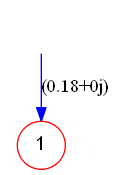

In [7]:
path='Benchmarks2/'

num=5

file_name='DQC_qft_'+str(num)+'.qasm'
file_name2='DQC_qft_'+str(num)+'_1.qasm'

cir1= QuantumCircuit.from_qasm_file(path+file_name)
cir2= QuantumCircuit.from_qasm_file(path+file_name2)

index_set=[]
for k in range(len(cir1._qubits)-1):
    index_set.append('x'+str(k))
    index_set.append('y'+str(k))

v=np.array([1,0])
input_state1=dict()
input_state2=dict()
for k in range(num):
    input_state1[k]=v
    input_state2[k]=v  
    
t_start=time.time()
tdd1,tdd2,max_nodes_num,res,time_dd = m_Equivalence(cir1,cir2,index_set,input_state1,input_state2)
t_end=time.time()
print('Is equal:',res)
print('time:',t_end-t_start)
print('time dd:',time_dd)
print('tdd1_node_num_final:',tdd1.node_number())
print('tdd2_node_num_final:',tdd2.node_number())
print('node_num_max:',max_nodes_num)
tdd2.show()
# cir1.draw()
# Equivalence_checking_of_DQC(cir1,cir2)

Is equal: True
time: 0.2979576587677002
time dd: 0.11300039291381836
tdd1_node_num_final: 7
tdd2_node_num_final: 7
node_num_max: 96


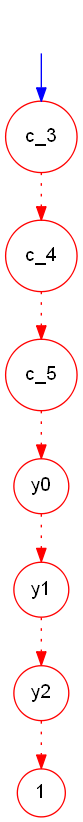

In [8]:
path='Benchmarks/'

file_name='bitflip_code.qasm'
file_name2='DQC_bitflip_code.qasm'
index_set=['y3','y4','y5']
v=np.array([1,0])
input_state1={0:v,1:v,2:v,3:v,4:v,5:v}
input_state2={0:v,1:v,2:v,3:v,4:v,5:v}

# file_name='phaseflip_code.qasm'
# file_name2='DQC_phaseflip_code.qasm'
# index_set=['y3','y4','y5']
# v=np.array([1,0])
# input_state1={0:v,1:v,2:v,3:v,4:v,5:v}
# input_state2={0:v,1:v,2:v,3:v,4:v,5:v}

# file_name='teleportation.qasm'
# file_name2='DQC_teleportation.qasm'
# index_set=['y0','y1']
# v=np.array([1,0])
# input_state1={1:v,2:v}
# input_state2={1:v,2:v}

# file_name='state_injection_S.qasm'
# file_name2='DQC_state_injection_S.qasm'
# index_set=['y1']
# v=np.array([1,1j])
# input_state1={1:v}
# input_state2={1:v}

# file_name='state_injection_T.qasm'
# file_name2='DQC_state_injection_T.qasm'
# index_set=['y1']
# v=np.array([1,complex(np.cos(np.pi/4),np.sin(np.pi/4))])
# input_state1={1:v}
# input_state2={1:v}


cir1= QuantumCircuit.from_qasm_file(path+file_name)
cir2= QuantumCircuit.from_qasm_file(path+file_name2)

t_start=time.time()
tdd1,tdd2,max_nodes_num,res,time_dd = q_Equivalence(cir1,cir2,index_set,input_state1,input_state2)
t_end=time.time()
print('Is equal:',res)
print('time:',t_end-t_start)
print('time dd:', time_dd)
print('tdd1_node_num_final:',tdd1.node_number())
print('tdd2_node_num_final:',tdd2.node_number())
print('node_num_max:',max_nodes_num)
tdd1.show()
# cir1.draw()

In [9]:
# path='Benchmarks2/'

# excel_path = 'data/data2.xlsx'


# data=['Benchmarks','qubits','gate1','gate2','res','time','nodes1','node2','max_nodes']        
# data=np.array(data).reshape(1,len(data))
# df = pd.read_excel(excel_path, header=None)
# ds = pd.DataFrame(data)
# df = df.append(ds, ignore_index=True)
# df.to_excel(excel_path, index=False, header=False)        
        
# for q in range(12,13):

#     file_name='DQC_qft_'+str(q)+'.qasm'
#     file_name2='DQC_qft_'+str(q)+'_2.qasm'
#     cir1= QuantumCircuit.from_qasm_file(path+file_name)
#     cir2= QuantumCircuit.from_qasm_file(path+file_name2)
    
#     data = []
#     print('file_name:',file_name)
#     data.append(file_name)
#     data.append(q)
#     data.append(get_gate_num(cir1))
#     data.append(get_gate_num(cir2))
    
#     index_set=[]
#     for k in range(len(cir1._qubits)-1):
#         index_set.append('x'+str(k))
#         index_set.append('y'+str(k))

#     v=np.array([1,0])
#     input_state1=dict()
#     input_state2=dict()
#     for k in range(q):
#         input_state1[k]=v
#         input_state2[k]=v  
        
#     t_start=time.time()
#     tdd1,tdd2,max_nodes_num,res,time_dd = m_Equivalence(cir1,cir2,index_set,input_state1,input_state2)
#     t_end=time.time()
#     print('Is equal:',res)
#     print('time:',t_end-t_start)
#     print('time dd:',time_dd)
#     print('tdd1_node_num_final:',tdd1.node_number())
#     print('tdd2_node_num_final:',tdd2.node_number())
#     print('node_num_max:',max_nodes_num)

#     data.append(res)
#     data.append(t_end-t_start)
#     data.append(time_dd)
#     data.append(tdd1.node_number())
#     data.append(tdd2.node_number())
#     data.append(max_nodes_num)


#     data=np.array(data).reshape(1,len(data))
#     df = pd.read_excel(excel_path, header=None)
#     ds = pd.DataFrame(data)
#     df = df.append(ds, ignore_index=True)
#     df.to_excel(excel_path, index=False, header=False)
#     print('---------------------')

file_name: DQC_bitflip_code.qasm
Is equal: True
time: 0.4869518280029297
time dd: 0.12392783164978027
tdd1_node_num_final: 56
tdd2_node_num_final: 56
node_num_max: 90
{-1: -1, 0: 'y2', 1: 'x2', 2: 'y1', 3: 'x1', 4: 'y0', 5: 'x0', 6: 'c_5', 7: 'c_4', 8: 'c_3', 9: 'c_2', 10: 'c_1', 11: 'c_0'}
{-1: -1, 'y2': 0, 'x2': 1, 'y1': 2, 'x1': 3, 'y0': 4, 'x0': 5, 'c_5': 6, 'c_4': 7, 'c_3': 8, 'c_2': 9, 'c_1': 10, 'c_0': 11}
11
('c_0', 0)
('c_0', 3)
('c_1', 0)
('c_1', 3)
('c_2', 0)
('c_2', 3)
('c_3', 3)
('c_4', 3)
('c_5', 3)
('x0', 0)
('y0', 0)
('x1', 0)
('y1', 0)
('x2', 0)
('y2', 0)


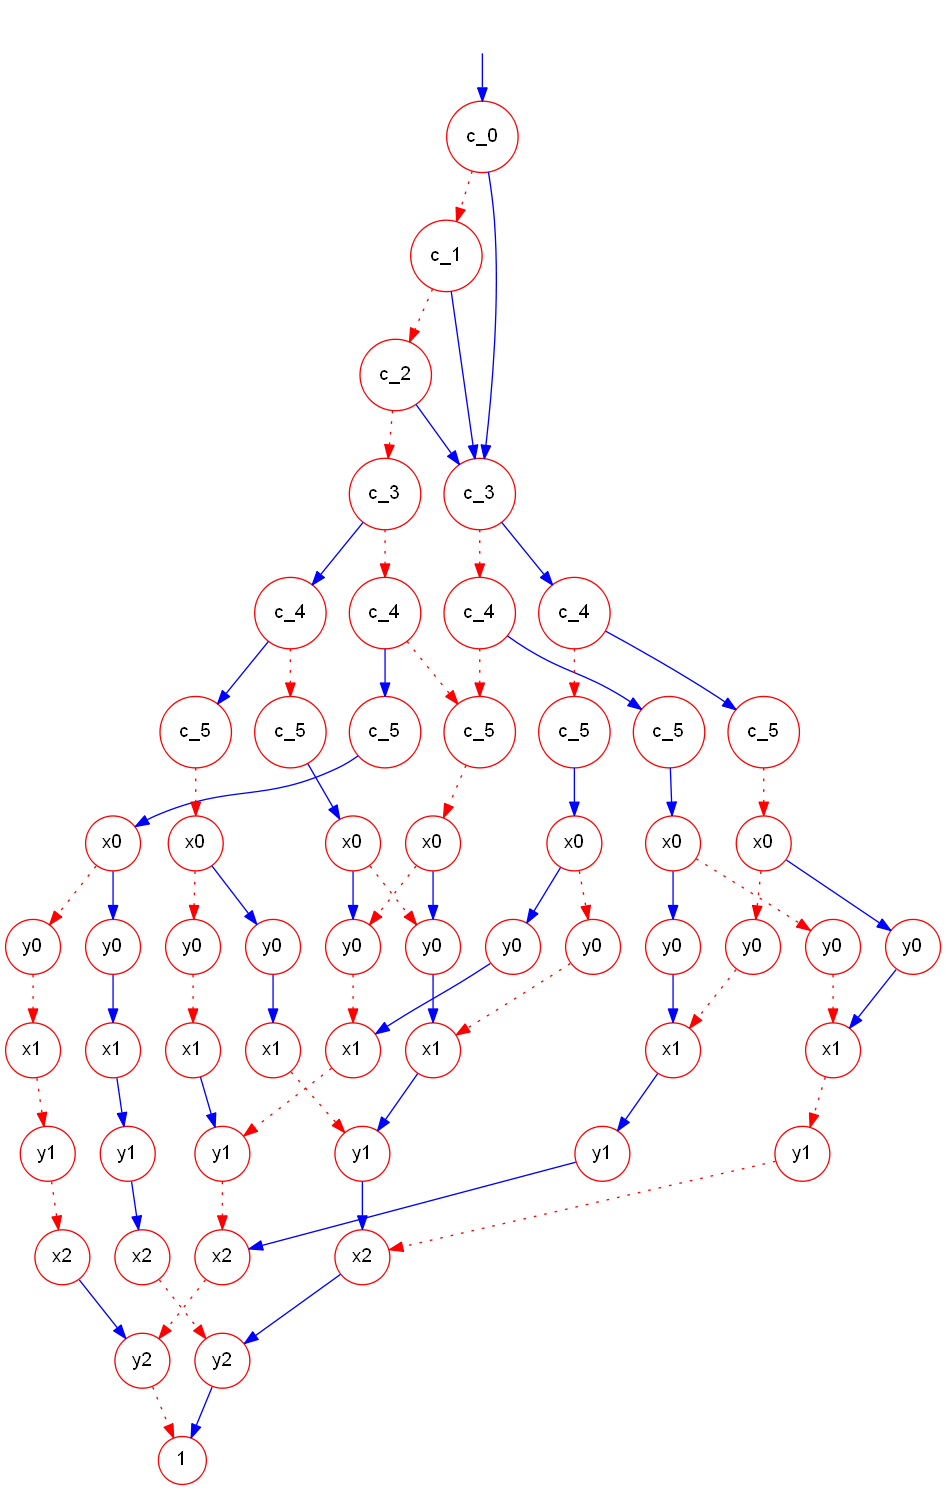

In [10]:
path='Benchmarks2/'

# excel_path = 'data/data2.xlsx'


# data=['Benchmarks','qubits','gate1','gate2','res','time','nodes1','node2','max_nodes']        
# data=np.array(data).reshape(1,len(data))
# df = pd.read_excel(excel_path, header=None)
# ds = pd.DataFrame(data)
# df = df.append(ds, ignore_index=True)
# df.to_excel(excel_path, index=False, header=False)        
        

file_name='DQC_bitflip_code.qasm'
file_name2='DQC_bitflip_code_1.qasm'
index_set=['y3','y4','y5']
v=np.array([1,0])
# input_state1={0:v,1:v,2:v,3:v,4:v,5:v}
# input_state2={0:v,1:v,2:v,3:v,4:v,5:v}
input_state1={3:v,4:v,5:v}
input_state2={3:v,4:v,5:v}

# file_name='DQC_phaseflip_code.qasm'
# file_name2='DQC_phaseflip_code_1.qasm'
# index_set=['y3','y4','y5']
# v=np.array([1,0])
# input_state1={0:v,1:v,2:v,3:v,4:v,5:v}
# input_state2={0:v,1:v,2:v,3:v,4:v,5:v}

# file_name='DQC_teleportation.qasm'
# file_name2='DQC_teleportation_1.qasm'
# index_set=['y0','y1']
# v=np.array([1,0])
# input_state1={1:v,2:v}
# input_state2={1:v,2:v}

# file_name='DQC_state_injection_S.qasm'
# file_name2='DQC_state_injection_S_1.qasm'
# index_set=['y1']
# v=np.array([1,1j])
# input_state1={1:v}
# input_state2={1:v}

# file_name='DQC_state_injection_T.qasm'
# file_name2='DQC_state_injection_T_1.qasm'
# index_set=['y1']
# v=np.array([1,complex(np.cos(np.pi/4),np.sin(np.pi/4))])
# input_state1={1:v}
# input_state2={1:v}

# data = []
print('file_name:',file_name)
# data.append(file_name)
cir1= QuantumCircuit.from_qasm_file(path+file_name)
cir2= QuantumCircuit.from_qasm_file(path+file_name2)

# data.append(len(cir1._qubits))
# data.append(get_gate_num(cir1))
# data.append(get_gate_num(cir2))

t_start=time.time()
tdd1,tdd2,max_nodes_num,res,time_dd = q_Equivalence(cir1,cir2,index_set,input_state1,input_state2)
t_end=time.time()
print('Is equal:',res)
print('time:',t_end-t_start)
print('time dd:', time_dd)
print('tdd1_node_num_final:',tdd1.node_number())
print('tdd2_node_num_final:',tdd2.node_number())
print('node_num_max:',max_nodes_num)
print(tdd1.key_2_index)
print(tdd1.index_2_key)
print(tdd1.node.key)
for k in tdd1.index_set:
    print(k)
tdd1.show()

# data.append(res)
# data.append(t_end-t_start)
# data.append(time_dd)
# data.append(tdd1.node_number())
# data.append(tdd2.node_number())
# data.append(max_nodes_num)


# data=np.array(data).reshape(1,len(data))
# df = pd.read_excel(excel_path, header=None)
# ds = pd.DataFrame(data)
# df = df.append(ds, ignore_index=True)
# df.to_excel(excel_path, index=False, header=False)
# print('---------------------')

Is equal: True
time: 0.06905531883239746
time dd: 0.05301499366760254
tdd1_node_num_final: 17
tdd2_node_num_final: 17
node_num_max: 17
('c_0', 0)
('x0', 0)
('y0', 0)
('x1', 0)
('y1', 0)
('x2', 0)
('y2', 0)


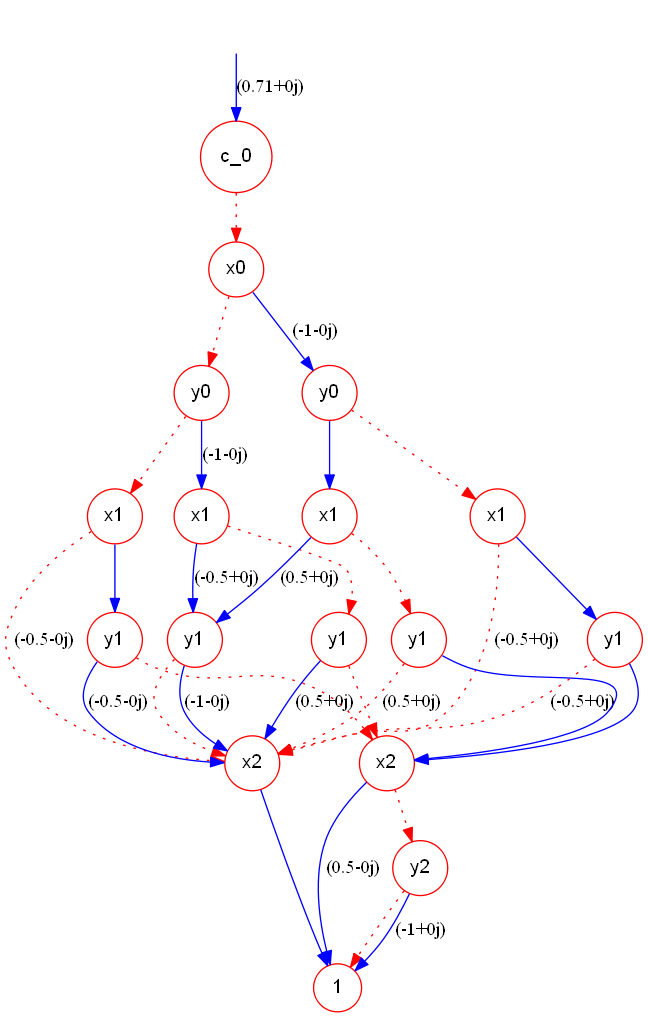

In [11]:
path='Benchmarks2/'

file_name='Grover_1.qasm'
file_name2='Grover_2.qasm'
index_set=['y3']
v=np.array([1,0])
input_state1={3:v}
input_state2={3:v}

cir1= QuantumCircuit.from_qasm_file(path+file_name)
cir2= QuantumCircuit.from_qasm_file(path+file_name2)

t_start=time.time()
tdd1,tdd2,max_nodes_num,res,time_dd = q_Equivalence(cir1,cir2,index_set,input_state1,input_state2)
t_end=time.time()
print('Is equal:',res)
print('time:',t_end-t_start)
print('time dd:', time_dd)
print('tdd1_node_num_final:',tdd1.node_number())
print('tdd2_node_num_final:',tdd2.node_number())
print('node_num_max:',max_nodes_num)
for k in tdd1.index_set:
    print(k)
tdd1.show()
# cir1.draw()

('c_0', 0)
('x0', 0)
('y0', 0)
('x1', 0)
('y1', 0)
('x2', 0)
('y2', 0)


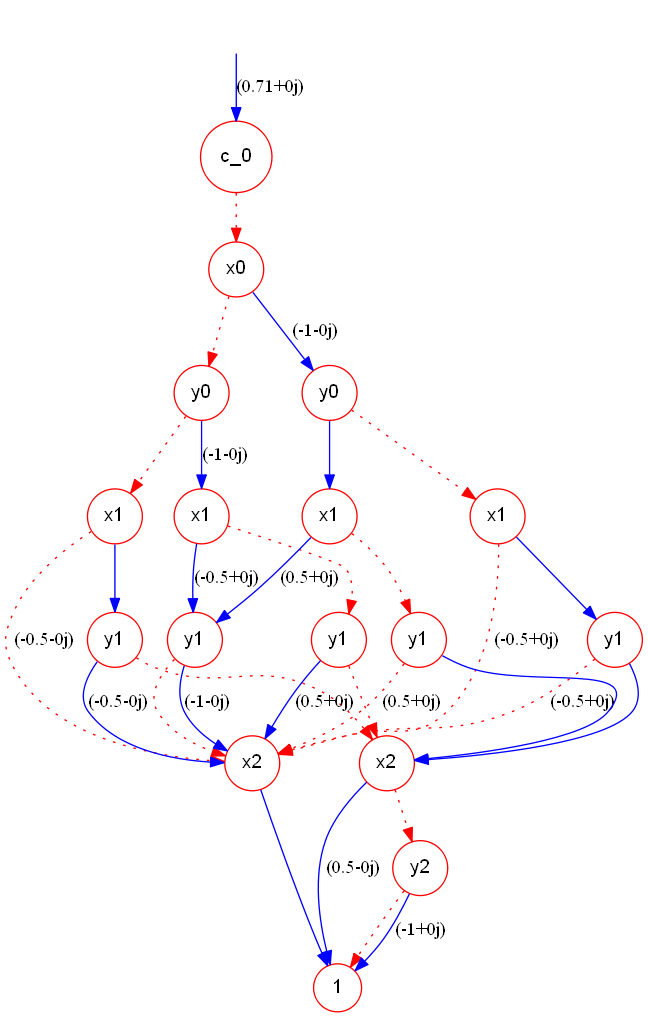

In [12]:
for k in tdd2.index_set:
    print(k)
tdd2.show()

In [13]:
cir1.draw()

┌───┐                         ┌───┐┌───┐          ┌───┐┌───┐     
q_0: ┤ H ├───────■──────────────■──┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
     ├───┤       │              │  ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐
q_1: ┤ H ├───────┼─────────■────┼──┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├
     ├───┤┌───┐  │  ┌───┐┌─┴─┐  │  └───┘└───┘└───┘└───┘└───┘└───┘└───┘
q_2: ┤ X ├┤ H ├──┼──┤ X ├┤ X ├──┼─────────────────────────────────────
     └───┘└───┘┌─┴─┐└─┬─┘└─┬─┘┌─┴─┐ ┌─┐                               
q_3: ──────────┤ X ├──■────■──┤ X ├─┤M├───────────────────────────────
               └───┘          └───┘ └╥┘                               
c: 1/════════════════════════════════╩════════════════════════════════
                                     0

In [14]:
cir2.draw()

┌───┐               ┌───┐┌───┐          ┌───┐┌───┐     
q_0: ┤ H ├───────■────■──┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
     ├───┤       │    │  ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐
q_1: ┤ H ├───────┼────■──┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├
     ├───┤┌───┐┌─┴─┐┌─┴─┐└───┘└───┘└───┘└───┘└───┘└───┘└───┘
q_2: ┤ X ├┤ H ├┤ X ├┤ X ├───────────────────────────────────
     └┬─┬┘└───┘└───┘└───┘                                   
q_3: ─┤M├───────────────────────────────────────────────────
      └╥┘                                                   
c: 1/══╩════════════════════════════════════════════════════
       0